In [1]:
import requests

# For dates
import datetime as dt
from dateutil.relativedelta import relativedelta

# For data analysis
import dtale
import numpy as np
import pandas as pd
import seaborn as sns
from scipy import stats
import statsmodels as sm
import matplotlib.pyplot as plt
from statsmodels.graphics.api import qqplot
from statsmodels.tsa.filters.hp_filter import hpfilter

# External resources
from yahoo_fin.stock_info import get_data

In [2]:
%matplotlib inline

First, we would obtain the data for one company and analyze it.

Then, once we know how this is done manually, we will automate this extraction.

This data will be stored in our database, as well as in a S3 bucket.

# Amazon Prices Weekly

In [3]:
# If we have no data of the company, we extract last 3 years
to_substract = dt.date.today() - relativedelta(years=3)

In [4]:
amazon_weekly= get_data(
    "amzn", 
    start_date=to_substract, 
    index_as_date = True, 
    interval="1d")

In [6]:
dtale.show(amazon_weekly)

In [9]:
# We will now make an analysis of this data
amazon_weekly.describe()

,open,high,low,close,adjclose,volume
count,754.000000,754.000000,754.000000,754.000000,754.000000,7.540000e+02
mean,141.632562,143.388820,139.741514,141.558779,141.558779,7.921137e+07
std,29.398197,29.558752,29.073675,29.262229,29.262229,3.529164e+07
min,82.075500,86.250000,81.301498,83.830498,83.830498,1.762600e+07
25%,117.142498,119.128374,115.543751,117.373249,117.373249,5.546050e+07
50%,154.917999,156.671997,151.998497,154.533752,154.533752,6.880200e+07
75%,164.800995,166.334381,162.969631,164.676750,164.676750,9.318300e+07
max,187.199997,188.654007,184.839493,186.570496,186.570496,3.113460e+08


### Handling NaNs

In [10]:
# Check if there are any null values
amazon_weekly.isnull().sum(axis=0)

open        0
high        0
low         0
close       0
adjclose    0
volume      0
ticker      0
dtype: int64

In [11]:
# We would not know if for some company we would have any null value, and is something we would have to handle
if amazon_weekly.isnull().any().sum() != 0:
    
    # We wou'ld fill the na with the last valid value
    amazon_weekly.fillna(method="backfill")

In [12]:
# A function would be like the following
def handle_nan(df, method="backfill"):
    
    return df.fillna(method=method)

### Visualize Evolution

Text(0, 0.5, 'Price in $ of each Share')

2022-09-27 09:04:59,721 - WARNING  - findfont: Font family ['Heiti TC'] not found. Falling back to DejaVu Sans.
2022-09-27 09:04:59,727 - WARNING  - findfont: Font family ['Heiti TC'] not found. Falling back to DejaVu Sans.


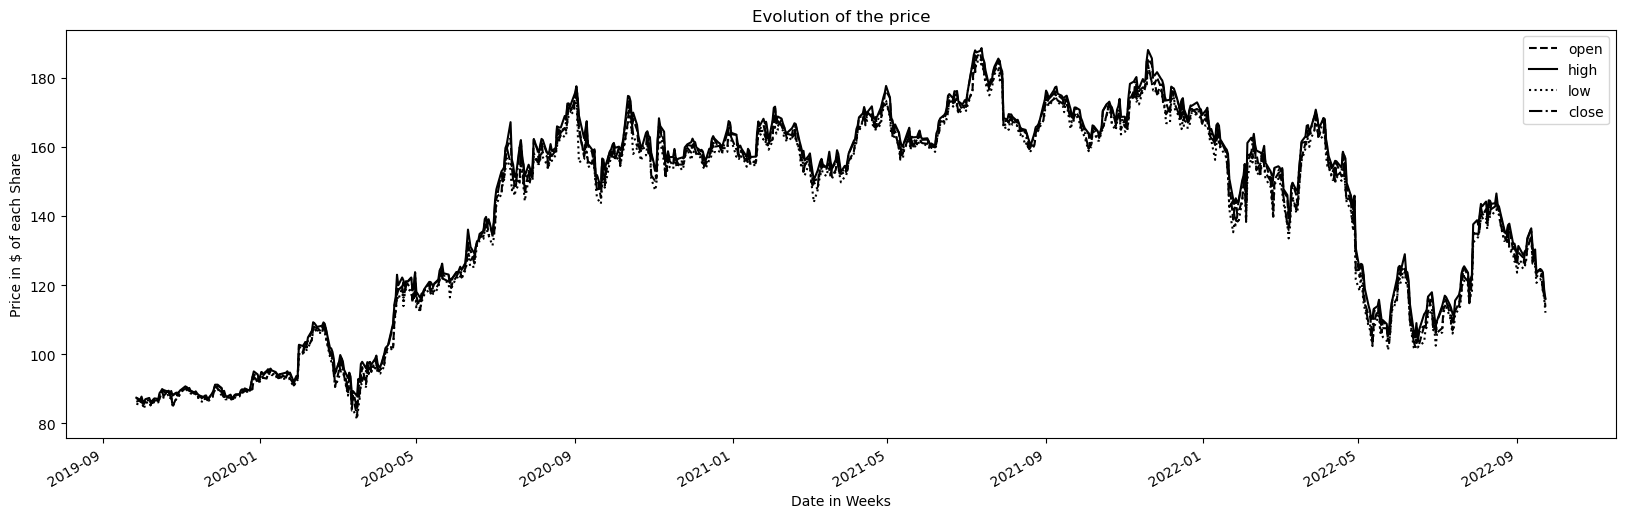

In [13]:
# We can make a plot of the evolution of the prices
amazon_weekly["open"].plot(figsize=(20,6), linestyle="--", color="black", legend="Open Price of Week")
amazon_weekly["high"].plot(figsize=(20,6), linestyle="-", color="black", legend="High Price of Week")
amazon_weekly["low"].plot(figsize=(20,6), linestyle=":", color="black", legend="Low Price of Week")
amazon_weekly["close"].plot(figsize=(20,6), linestyle="-.", color="black", legend="Close Price of Week")

plt.title("Evolution of the price")
plt.xlabel("Date in Weeks")
plt.ylabel("Price in $ of each Share")

### Handling Outliers

In this case we do not have outliers, but it is one scenario we would have to handle.

There are two ways to check for outliers:
- **Inter-Quantile Range**: we use extreme percentil values, of 5% and 95%, to minimize risk of removing correct data points.
- **Z-Score**: represents the distance of the data point in the number of standard deviations away from mean. For a large dataset, for the rule of large numbers, there is 1% chance of a data point having a value of >= 3.

In [7]:
# We will use stats to compute the z-score
prices_amazon = amazon_weekly.drop(["adjclose", "volume", "ticker"], axis=1)

In [15]:
# We can compute the Z-Score in the following way
stats.zscore(prices_amazon)

,open,high,low,close
2019-09-27,-1.845983,-1.893515,-1.860322,-1.890593
2019-09-30,-1.881740,-1.913252,-1.868238,-1.872709
2019-10-01,-1.849386,-1.882547,-1.835214,-1.873153
2019-10-02,-1.880463,-1.927758,-1.875500,-1.911487
2019-10-03,-1.905550,-1.934342,-1.909815,-1.892355
...,...,...,...,...
2022-09-19,-0.662812,-0.632341,-0.617515,-0.577878
2022-09-20,-0.622307,-0.642836,-0.640231,-0.662343
2022-09-21,-0.651580,-0.664502,-0.732816,-0.787160
2022-09-22,-0.835727,-0.832753,-0.808192,-0.829222


In [16]:
# And now we can see if some absolute value of z-score is higher than 3 (would be a parameter of sensibility)
prices_amazon[(np.abs(stats.zscore(prices_amazon)) > 3).all(axis=1)]

,open,high,low,close


In [9]:
# And in the case of outliers, we would remove them by index
prices_amazon_cleaned = prices_amazon.\
    drop(prices_amazon[(np.abs(stats.zscore(prices_amazon)) > 3).all(axis=1)].index)
prices_amazon_cleaned

,open,high,low,close
2019-09-27,87.400002,87.456001,85.691002,86.272499
2019-09-30,86.349503,86.873001,85.460999,86.795502
2019-10-01,87.300003,87.779999,86.420502,86.782501
2019-10-02,86.387001,86.444504,85.250000,85.661499
2019-10-03,85.650002,86.250000,84.252998,86.221001
...,...,...,...,...
2022-09-19,122.160004,124.709999,121.800003,124.660004
2022-09-20,123.349998,124.400002,121.139999,122.190002
2022-09-21,122.489998,123.760002,118.449997,118.540001
2022-09-22,117.080002,118.790001,116.260002,117.309998


In [18]:
# So the function would be the following
def clean_outliers_z_score(df, threshold):
    return df.drop(df[(np.abs(stats.zscore(df)) > threshold).all(axis=1)].index)

In [57]:
# And we will also apply the inter quantile range
first_quantile = delta_prices_perc["Delta Open Perc"].quantile(.25)
third_quantile = delta_prices_perc["Delta Open Perc"].quantile(.75)
inter_quantile_range = third_quantile - first_quantile

print("First quantile: ", first_quantile)
print("Third quantile: ", third_quantile)
print("Inter quantile range: ", inter_quantile_range)

First quantile:  -0.011181817575807895
Third quantile:  0.012538933285877232
Inter quantile range:  0.023720750861685125


In [58]:
# And we will get rid of the oned that are 1.5 * first/third_quantile
delta_prices_perc[delta_prices_perc["Delta Open Perc"] < -1.5 * inter_quantile_range - first_quantile]

,Delta Open Perc,Delta High Perc,Delta Low Perc,Delta Close Perc
2019-10-24,-0.043321,-0.013677,-0.038507,-0.011043
2019-12-02,-0.025227,-0.018433,-0.008843,-0.006576
2020-01-24,-0.039214,-0.029326,-0.017683,-0.018213
2020-02-21,-0.069375,-0.051611,-0.050318,-0.043140
2020-02-25,-0.028493,-0.009892,0.001035,0.003460
...,...,...,...,...
2022-08-26,-0.051193,-0.044562,-0.013435,-0.007397
2022-08-31,-0.027381,-0.020075,-0.024907,0.008215
2022-09-13,-0.028659,-0.019870,0.000475,0.013458
2022-09-15,-0.037465,-0.052474,-0.039768,-0.022262


In [59]:
delta_prices_perc[delta_prices_perc["Delta Open Perc"] > 1.5 * inter_quantile_range + third_quantile]

,Delta Open Perc,Delta High Perc,Delta Low Perc,Delta Close Perc
2020-01-30,0.094308,0.088947,0.075744,0.068720
2020-02-28,0.048183,0.033129,0.031481,0.035927
2020-03-09,0.051858,0.016629,0.031284,0.048213
2020-03-16,0.075450,0.052929,0.037419,0.065653
2020-03-18,0.059140,0.053131,0.047827,0.027077
2020-03-23,0.063413,0.018210,0.046486,0.019210
2020-04-13,0.072925,0.048866,0.067793,0.050124
2020-07-01,0.052891,0.020490,0.040786,0.004013
2020-07-20,0.071861,0.012103,0.035966,-0.018657
2020-07-30,0.070900,0.047684,0.046335,0.035643


In [60]:
# So the function would be the following
def clean_outliers_iqr(df, field, threshold):
    df = df.drop(df[
        df[field] < -threshold * inter_quantile_range - first_quantile
    ].index, axis=0)
    
    df = df.drop(df[
        df[field] > threshold * inter_quantile_range + first_quantile
    ].index, axis=0)
    
    return df

In [61]:
# TODO: Maybe first remove non-stationarity
clean_outliers_iqr(delta_prices_perc, "Delta Open Perc", 2.5)

,Delta Open Perc,Delta High Perc,Delta Low Perc,Delta Close Perc
2019-09-27,-0.012166,-0.006711,-0.002691,0.006026
2019-09-30,0.010888,0.010333,0.011103,-0.000150
2019-10-01,-0.010569,-0.015449,-0.013730,-0.013086
2019-10-02,-0.008605,-0.002255,-0.011833,0.006489
2019-10-03,0.007543,0.008951,0.019875,0.008755
...,...,...,...,...
2022-09-19,0.009647,-0.002492,-0.005448,-0.020214
2022-09-20,-0.007021,-0.005171,-0.022710,-0.030791
2022-09-21,-0.046208,-0.041839,-0.018837,-0.010485
2022-09-22,-0.009310,-0.023610,-0.037480,-0.031025


In [62]:
delta_prices_perc

,Delta Open Perc,Delta High Perc,Delta Low Perc,Delta Close Perc
2019-09-27,-0.012166,-0.006711,-0.002691,0.006026
2019-09-30,0.010888,0.010333,0.011103,-0.000150
2019-10-01,-0.010569,-0.015449,-0.013730,-0.013086
2019-10-02,-0.008605,-0.002255,-0.011833,0.006489
2019-10-03,0.007543,0.008951,0.019875,0.008755
...,...,...,...,...
2022-09-19,0.009647,-0.002492,-0.005448,-0.020214
2022-09-20,-0.007021,-0.005171,-0.022710,-0.030791
2022-09-21,-0.046208,-0.041839,-0.018837,-0.010485
2022-09-22,-0.009310,-0.023610,-0.037480,-0.031025


### Univariate Analysis

In [20]:
# Next thing to do, is to make an univariate and bivariate analysis
delta_prices = prices_amazon_cleaned.shift(-1) - prices_amazon_cleaned
delta_prices = delta_prices.fillna(0)
delta_prices.columns = ["Delta Open", "Delta High", "Delta Low", "Delta Close"]
delta_prices

,Delta Open,Delta High,Delta Low,Delta Close
2019-09-27,-1.050499,-0.583000,-0.230003,0.523003
2019-09-30,0.950500,0.906998,0.959503,-0.013000
2019-10-01,-0.913002,-1.335495,-1.170502,-1.121002
2019-10-02,-0.737000,-0.194504,-0.997002,0.559502
2019-10-03,0.651001,0.778999,1.708504,0.761497
...,...,...,...,...
2022-09-19,1.189995,-0.309998,-0.660004,-2.470001
2022-09-20,-0.860001,-0.639999,-2.690002,-3.650002
2022-09-21,-5.409996,-4.970001,-2.189995,-1.230003
2022-09-22,-1.080002,-2.739998,-4.200005,-3.529999


In [21]:
delta_prices.describe()

,Delta Open,Delta High,Delta Low,Delta Close
count,754.000000,754.000000,754.000000,754.000000
mean,0.037931,0.037923,0.034972,0.036482
std,3.254046,2.847552,2.895845,3.170607
min,-13.989990,-15.176498,-18.675003,-20.314995
25%,-1.577377,-1.294247,-1.359379,-1.507633
50%,0.078506,0.007748,0.101997,0.122246
75%,1.656250,1.351997,1.567501,1.668243
max,13.869003,16.952499,14.330002,18.793991


<AxesSubplot:ylabel='Frequency'>

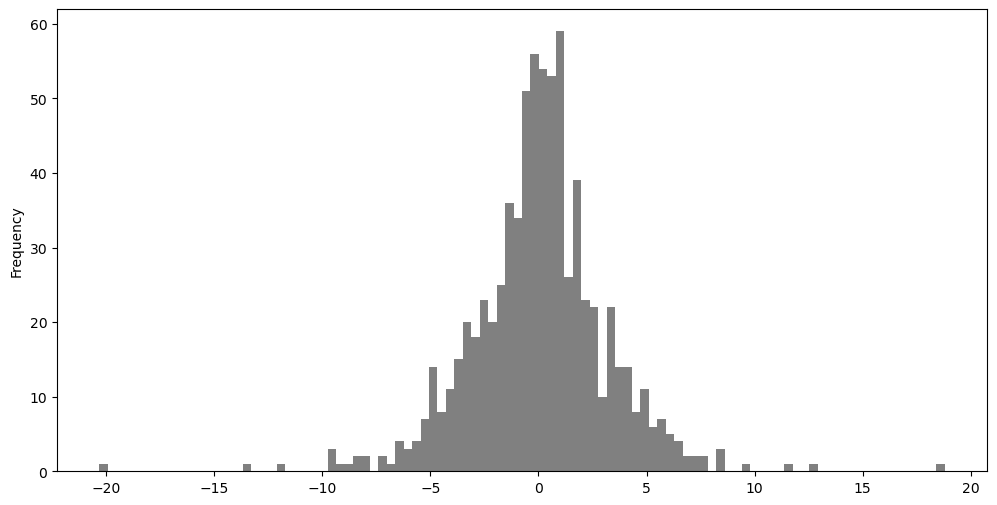

In [22]:
delta_prices["Delta Close"].plot(kind="hist", bins=100, figsize=(12, 6), color="gray")

We could see that the delta means are approximately around 0 in absolute values, but +

In [23]:
# Next thing to do, is to make an univariate and bivariate analysis
delta_prices_perc = (prices_amazon_cleaned.shift(-1) - prices_amazon_cleaned) / prices_amazon_cleaned.shift(-1)
delta_prices_perc = delta_prices_perc.fillna(0)
delta_prices_perc.columns = ["Delta Open Perc", "Delta High Perc", "Delta Low Perc", "Delta Close Perc"]
delta_prices_perc

,Delta Open Perc,Delta High Perc,Delta Low Perc,Delta Close Perc
2019-09-27,-0.012166,-0.006711,-0.002691,0.006026
2019-09-30,0.010888,0.010333,0.011103,-0.000150
2019-10-01,-0.010569,-0.015449,-0.013730,-0.013086
2019-10-02,-0.008605,-0.002255,-0.011833,0.006489
2019-10-03,0.007543,0.008951,0.019875,0.008755
...,...,...,...,...
2022-09-19,0.009647,-0.002492,-0.005448,-0.020214
2022-09-20,-0.007021,-0.005171,-0.022710,-0.030791
2022-09-21,-0.046208,-0.041839,-0.018837,-0.010485
2022-09-22,-0.009310,-0.023610,-0.037480,-0.031025


In [24]:
# And now we would see that the mean is around +0.2%
delta_prices_perc.describe()

,Delta Open Perc,Delta High Perc,Delta Low Perc,Delta Close Perc
count,754.000000,754.000000,754.000000,754.000000
mean,0.000093,0.000171,0.000128,0.000100
std,0.023813,0.020212,0.021415,0.023194
min,-0.094949,-0.116063,-0.153546,-0.163460
25%,-0.011182,-0.009022,-0.010192,-0.011199
50%,0.000469,0.000061,0.000762,0.000836
75%,0.012539,0.009465,0.011072,0.011648
max,0.098814,0.107592,0.108224,0.119221


<AxesSubplot:ylabel='Frequency'>

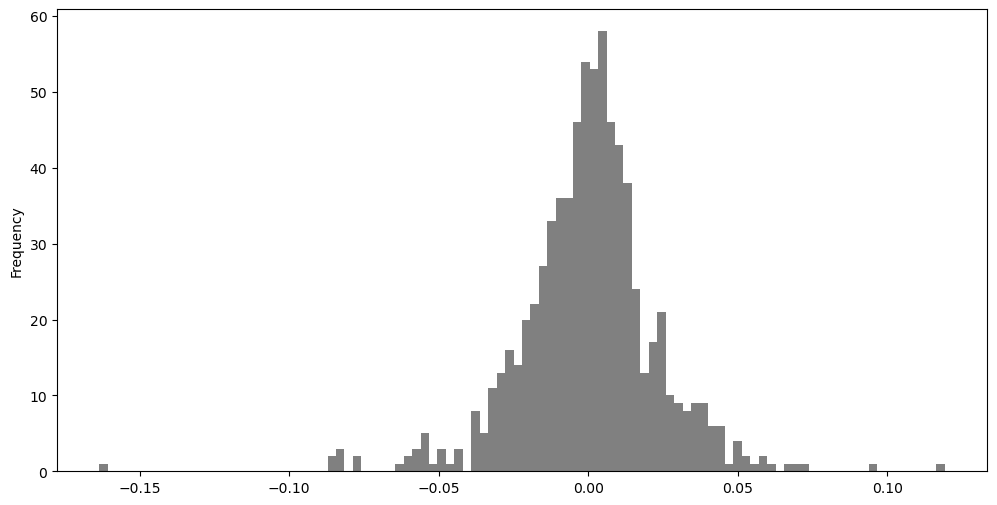

In [25]:
delta_prices_perc["Delta Close Perc"].plot(kind="hist", bins=100, figsize=(12, 6), color="gray")

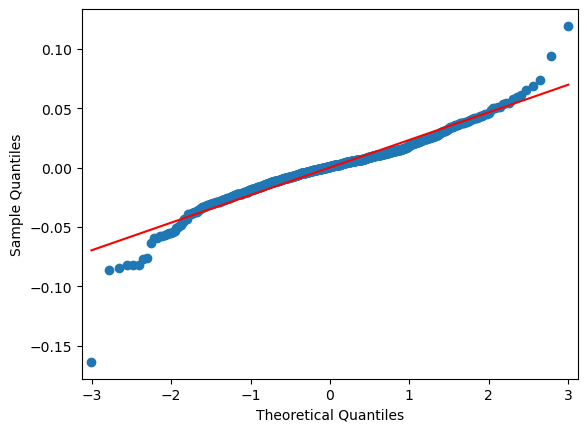

In [26]:
# We could make a normal distribution test with Q-Q plot
fig = qqplot(delta_prices_perc["Delta Close Perc"], line="s")

We can see that with large numbers, the variations of the prices follow a normal distribution.

Also, we can see that overall, that the QQ plot has an overlap of the lines in most part.

Having this assumption of normal distribution is important for many statistical methods.

<AxesSubplot:>

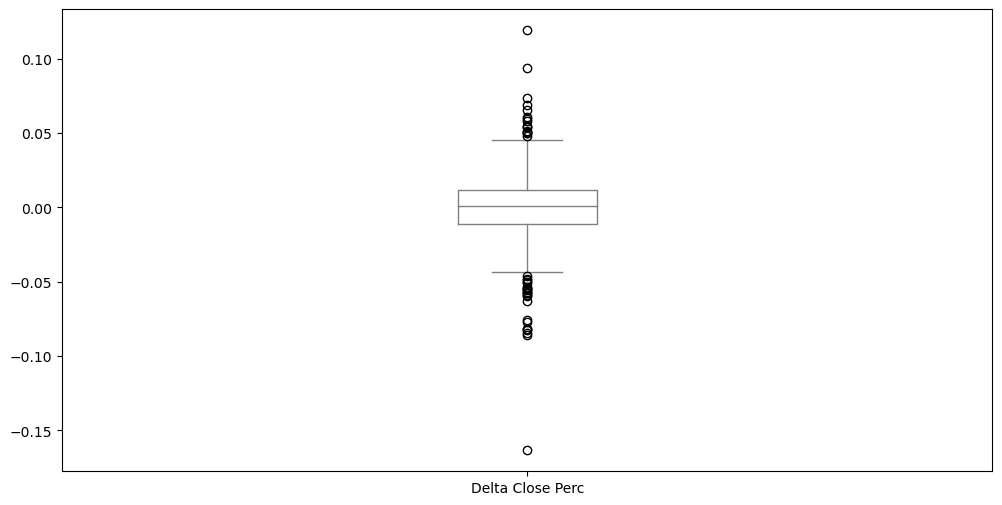

In [27]:
# We could also display a boxplot to know how it this variation
delta_prices_perc["Delta Close Perc"].plot(kind="box", figsize=(12, 6), color="gray")

In [63]:
delta_prices_perc[delta_prices_perc["Delta Open Perc"] > 1.5 * inter_quantile_range + third_quantile]

,Delta Open Perc,Delta High Perc,Delta Low Perc,Delta Close Perc
2020-01-30,0.094308,0.088947,0.075744,0.068720
2020-02-28,0.048183,0.033129,0.031481,0.035927
2020-03-09,0.051858,0.016629,0.031284,0.048213
2020-03-16,0.075450,0.052929,0.037419,0.065653
2020-03-18,0.059140,0.053131,0.047827,0.027077
2020-03-23,0.063413,0.018210,0.046486,0.019210
2020-04-13,0.072925,0.048866,0.067793,0.050124
2020-07-01,0.052891,0.020490,0.040786,0.004013
2020-07-20,0.071861,0.012103,0.035966,-0.018657
2020-07-30,0.070900,0.047684,0.046335,0.035643


In [29]:
delta_prices_perc

,Delta Open Perc,Delta High Perc,Delta Low Perc,Delta Close Perc
2019-09-27,-0.012166,-0.006711,-0.002691,0.006026
2019-09-30,0.010888,0.010333,0.011103,-0.000150
2019-10-01,-0.010569,-0.015449,-0.013730,-0.013086
2019-10-02,-0.008605,-0.002255,-0.011833,0.006489
2019-10-03,0.007543,0.008951,0.019875,0.008755
...,...,...,...,...
2022-09-19,0.009647,-0.002492,-0.005448,-0.020214
2022-09-20,-0.007021,-0.005171,-0.022710,-0.030791
2022-09-21,-0.046208,-0.041839,-0.018837,-0.010485
2022-09-22,-0.009310,-0.023610,-0.037480,-0.031025


### Bivariate Analysis

array([[<AxesSubplot:xlabel='Delta Open Perc', ylabel='Delta Open Perc'>,
        <AxesSubplot:xlabel='Delta High Perc', ylabel='Delta Open Perc'>,
        <AxesSubplot:xlabel='Delta Low Perc', ylabel='Delta Open Perc'>,
        <AxesSubplot:xlabel='Delta Close Perc', ylabel='Delta Open Perc'>],
       [<AxesSubplot:xlabel='Delta Open Perc', ylabel='Delta High Perc'>,
        <AxesSubplot:xlabel='Delta High Perc', ylabel='Delta High Perc'>,
        <AxesSubplot:xlabel='Delta Low Perc', ylabel='Delta High Perc'>,
        <AxesSubplot:xlabel='Delta Close Perc', ylabel='Delta High Perc'>],
       [<AxesSubplot:xlabel='Delta Open Perc', ylabel='Delta Low Perc'>,
        <AxesSubplot:xlabel='Delta High Perc', ylabel='Delta Low Perc'>,
        <AxesSubplot:xlabel='Delta Low Perc', ylabel='Delta Low Perc'>,
        <AxesSubplot:xlabel='Delta Close Perc', ylabel='Delta Low Perc'>],
       [<AxesSubplot:xlabel='Delta Open Perc', ylabel='Delta Close Perc'>,
        <AxesSubplot:xlabel='Delta Hig

2022-09-27 09:05:56,420 - WARNING  - findfont: Font family ['Heiti TC'] not found. Falling back to DejaVu Sans.


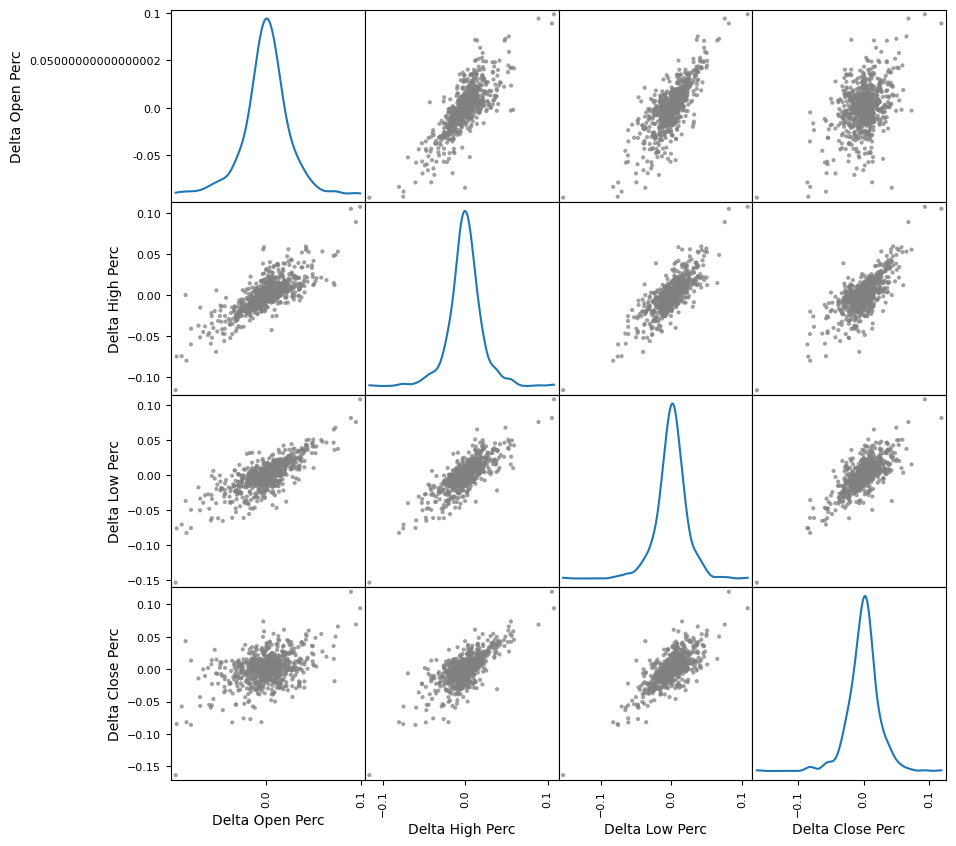

In [30]:
pd.plotting.\
    scatter_matrix(
        delta_prices_perc, 
        figsize=(10, 10), 
        color="gray", 
        alpha=0.75, 
        diagonal="kde")

<AxesSubplot:>

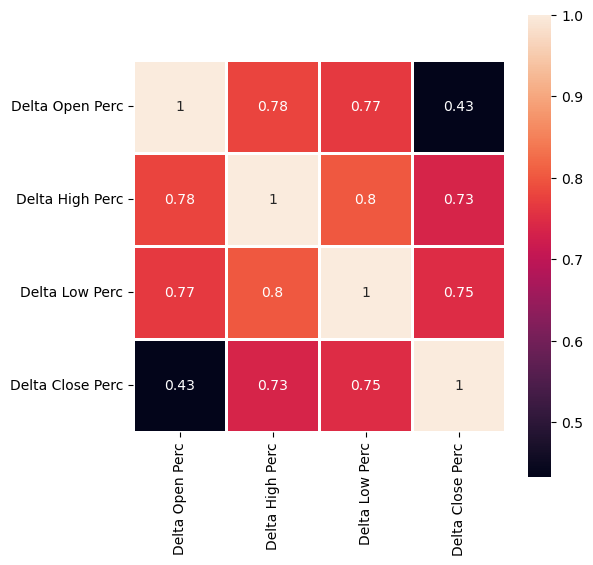

In [31]:
# We could create also a correlation heatmap
plt.figure(figsize=(6, 6))
sns.heatmap(delta_prices_perc.corr(), annot=True, square=True, linewidths=2)

In [32]:
agg_correlation = (delta_prices_perc.corr().sum(axis=0) - 1)
agg_correlation.idxmax()

'Delta Low Perc'

<AxesSubplot:>

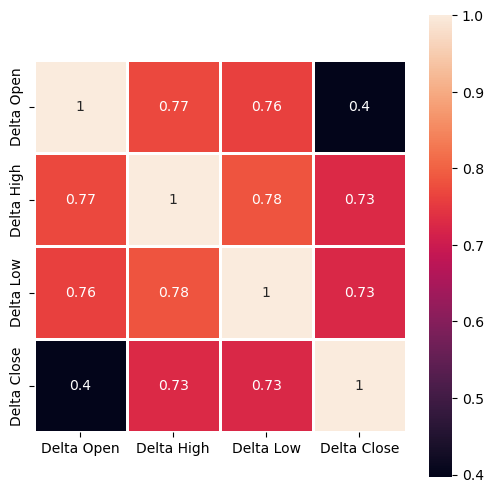

In [33]:
# We could look without percentages, if this relation holds
plt.figure(figsize=(6, 6))
sns.heatmap(delta_prices.corr(), annot=True, square=True, linewidths=2)

In [34]:
agg_correlation = (delta_prices.corr().sum(axis=0) - 1)
agg_correlation.idxmax()

'Delta High'

In this case, there is a difference between the delta_prices and delta_prices_perc of which is the one that has the most correlaiton with the other variables.

In [35]:
def get_max_corr_variable(df):
    agg_correlation = (df.corr().sum(axis=0) - 1)
    return agg_correlation.idxmax()

We could make predictions based on the begin, high, low, and closed and see which regression will work better.

### ETS Analysis

Stationary time series are time series which mean, variance and autocorrelation are constant over time.

Many statistical models assume that the time series they work with is transformed into stationary, with for example **differenciation**.

#### Hodrik-Presscot Decomposition

Could make a first analysis on trend, seasonality and error.

We will use Hodrick-Presscot Method, which is used to separate the trend and cyclical components.
We will use lambda smooth factor, [link](https://stats.stackexchange.com/questions/34646/determining-smoothing-parameter-in-hp-filter-for-hourly-data).

In [36]:
# we will use a lambda parameter to smooth the decomposition in weeks (HP is for data aggregation)
lamb = 52 ** 4 * 6.25
lamb

45697600.0

In [37]:
def get_lambda_smoother(frequency_period):
    # For a frequency of a month in a year, would be 12
    return frequency_period ** 4 * 6.25

In [10]:
# We aggregate the data by week
prices_amazon_week = prices_amazon_cleaned.resample("W").agg("sum")
prices_amazon_week

,open,high,low,close
2019-09-29,87.400002,87.456001,85.691002,86.272499
2019-10-06,431.987511,434.376503,427.346001,432.443001
2019-10-13,432.094498,434.425995,429.333496,430.617004
2019-10-20,441.433502,444.870491,438.217995,441.311508
2019-10-27,439.387505,444.913002,436.213493,442.783493
...,...,...,...,...
2022-08-28,673.690002,682.030014,662.680008,668.669998
2022-09-04,646.099991,654.010010,632.410004,640.619987
2022-09-11,512.670006,522.410004,507.999992,518.680008
2022-09-18,642.629997,650.969994,632.799995,641.629997


In [39]:
def get_resample_week(df):
    return df.resample("W").agg("sum")

In [40]:
hp_cycle, hp_trend = hpfilter(prices_amazon_week["open"], lamb=lamb)

decomposition = prices_amazon_week[["open"]]
decomposition["cycle"] = hp_cycle
decomposition["trend"] = hp_trend
decomposition

/tmp/ipykernel_11/1218759561.py:4: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/tmp/ipykernel_11/1218759561.py:5: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



,open,cycle,trend
2019-09-29,87.400002,-469.383781,556.783783
2019-10-06,431.987511,-126.482337,558.469848
2019-10-13,432.094498,-128.061405,560.155903
2019-10-20,441.433502,-120.408433,561.841935
2019-10-27,439.387505,-124.140423,563.527928
...,...,...,...
2022-08-28,673.690002,-112.466509,786.156511
2022-09-04,646.099991,-141.377379,787.477370
2022-09-11,512.670006,-276.128197,788.798203
2022-09-18,642.629997,-147.489028,790.119025


In [41]:
def get_week_decomposition_hp(df_weekly, field):
    decomposition = df_weekly[[field]]
    
    decomposition["hp_cycle"] = hp_cycle
    decomposition["hp_trend"] = hp_trend
    decomposition
    
    return decomposition

#### Unobserved Components

In [42]:
# We can also use this method to identify ETS components: Error, Trend & Seasonality
from statsmodels.tsa.statespace.structural import UnobservedComponents
uc = UnobservedComponents(
    prices_amazon_week["open"],
    level="lltrend",
    cycle=True,
    stochastic_cycle=True
)

res_uc = uc.fit(method="powell", disp=True)
res_uc.summary()

Optimization terminated successfully.
         Current function value: 5.644369
         Iterations: 5
         Function evaluations: 311


<class 'statsmodels.iolib.summary.Summary'>
"""
                        Unobserved Components Results                         
==============================================================================
Dep. Variable:                   open   No. Observations:                  157
Model:             local linear trend   Log Likelihood                -886.166
                   + stochastic cycle   AIC                           1782.332
Date:                Tue, 27 Sep 2022   BIC                           1797.484
Time:                        09:06:11   HQIC                          1788.487
Sample:                    09-29-2019                                         
                         - 09-25-2022                                         
Covariance Type:                  opg                                         
====================================================================================
                       coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------
sigma2.irregular  3548.7107    535.518      6.627      0.000    2499.115    4598.306
sigma2.level       802.6068    364.991      2.199      0.028      87.237    1517.976
sigma2.trend         0.6859      1.181      0.581      0.561      -1.629       3.001
sigma2.cycle      8.124e-18      5.254   1.55e-18      1.000     -10.298      10.298
frequency.cycle      1.6944      0.007    241.437      0.000       1.681       1.708
===================================================================================
Ljung-Box (L1) (Q):                   0.32   Jarque-Bera (JB):                 9.90
Prob(Q):                              0.57   Prob(JB):                         0.01
Heteroskedasticity (H):               1.16   Skew:                            -0.62
Prob(H) (two-sided):                  0.60   Kurtosis:                         2.88
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [43]:
def get_week_decomposition_uc(df_weekly, field):
    uc = UnobservedComponents(
        df_weekly[field],
        level="lltrend",
        cycle=True,
        stochastic_cycle=True
    )

    res_uc = uc.fit(method="powell", disp=True)
    
    # And now we create the new decomposition dataframe
    decomposition = df_weekly[[field]]
    decomposition["uc_cycle"] = res_uc.cycle.smoothed
    decomposition["uc_trend"] = res_uc.level.smoothed
    decomposition["uc_error"] = res_uc.resid
    return decomposition

In [44]:
get_week_decomposition_uc(prices_amazon_week, "open")

Optimization terminated successfully.
         Current function value: 5.644369
         Iterations: 5
         Function evaluations: 311


/tmp/ipykernel_11/3408738698.py:13: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/tmp/ipykernel_11/3408738698.py:14: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



,open,uc_cycle,uc_trend,uc_error
2019-09-29,87.400002,15.529117,284.628763,87.400002
2019-10-06,431.987511,13.938267,340.828865,393.741499
2019-10-13,432.094498,-18.964965,379.522835,0.433399
2019-10-20,441.433502,-9.263314,401.969765,15.523103
2019-10-27,439.387505,21.248416,413.315901,-352.250491
...,...,...,...,...
2022-08-28,673.690002,14.417331,645.012470,-18.535652
2022-09-04,646.099991,15.077782,628.598515,-40.787199
2022-09-11,512.670006,-18.134075,611.622000,-124.453814
2022-09-18,642.629997,-10.607647,612.922174,50.664504


#### Seasonal Decompose

In [45]:
from statsmodels.tsa.seasonal import seasonal_decompose

def get_week_decomposition_sd(df_weekly, field):
    # We can make the decomposition in an additive way
    s_dc = seasonal_decompose(df_weekly[field], model="additive")
    
    # And now we create the new decomposition dataframe
    decomposition = df_weekly[[field]]
    
    decomposition["sd_cycle"] = s_dc.seasonal
    decomposition["sd_trend"] = s_dc.trend
    decomposition["sd_error"] = s_dc.resid
    
    return decomposition

#### Comparing Results

In [46]:
prices_amazon_week_decomp_hp = get_week_decomposition_hp(prices_amazon_week, "open")
prices_amazon_week_decomp_uc = get_week_decomposition_uc(prices_amazon_week, "open")
prices_amazon_week_decomp_sd = get_week_decomposition_sd(prices_amazon_week, "open")

Optimization terminated successfully.
         Current function value: 5.644369
         Iterations: 5
         Function evaluations: 311


/tmp/ipykernel_11/2939252969.py:4: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/tmp/ipykernel_11/2939252969.py:5: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/tmp/ipykernel_11/3408738698.py:13: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/tmp/ipykernel_11/340873

<AxesSubplot:>

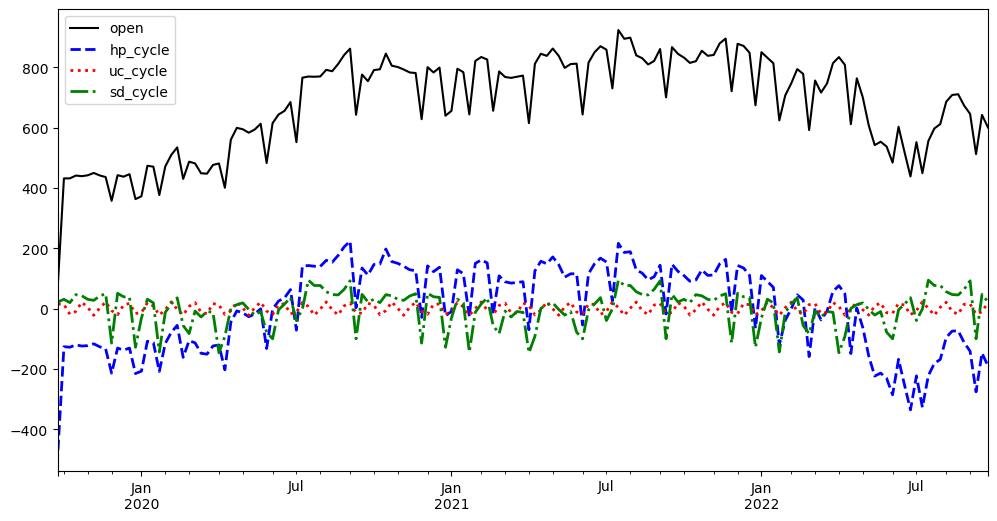

In [47]:
# We will print the cycles
prices_amazon_week["open"].plot(figsize=(12, 6), color="black", linestyle="-", legend="Price")

prices_amazon_week_decomp_hp["hp_cycle"].plot(
    figsize=(12, 6), 
    color="blue", 
    linestyle="--", 
    lw="2", 
    legend="HP Cycle"
)

prices_amazon_week_decomp_uc["uc_cycle"].plot(
    figsize=(12, 6), 
    color="red", 
    linestyle=":", 
    lw="2", 
    legend="UC Cycle"
)

prices_amazon_week_decomp_sd["sd_cycle"].plot(
    figsize=(12, 6), 
    color="green", 
    linestyle="-.", 
    lw="2", 
    legend="SD Cycle"
)

<AxesSubplot:>

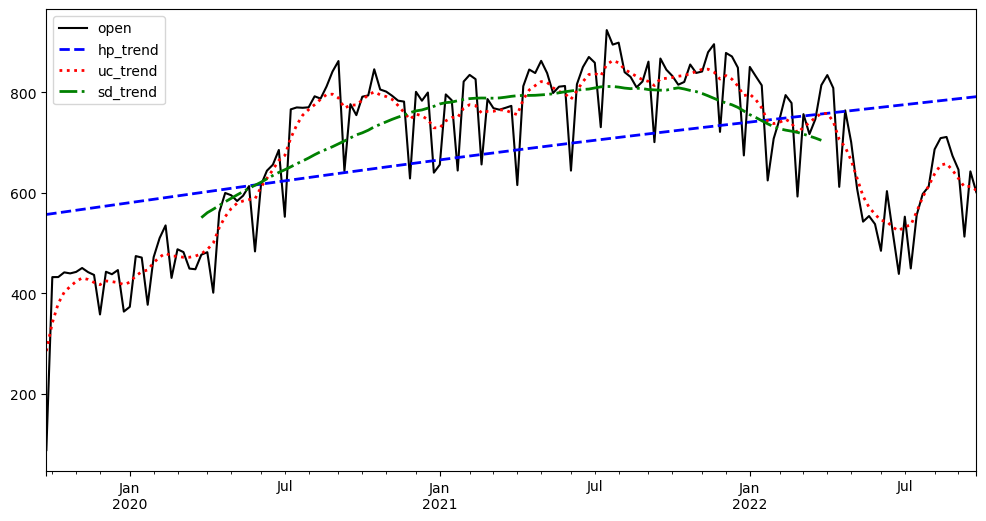

In [48]:
# We will print the cycles
prices_amazon_week["open"].plot(figsize=(12, 6), color="black", linestyle="-", legend="Price")

prices_amazon_week_decomp_hp["hp_trend"].plot(
    figsize=(12, 6), 
    color="blue", 
    linestyle="--", 
    lw="2", 
    legend="HP Trend"
)

prices_amazon_week_decomp_uc["uc_trend"].plot(
    figsize=(12, 6), 
    color="red", 
    linestyle=":", 
    lw="2", 
    legend="UC Trend"
)

prices_amazon_week_decomp_sd["sd_trend"].plot(
    figsize=(12, 6), 
    color="green", 
    linestyle="-.", 
    lw="2", 
    legend="SD Trend"
)

###### Trend
We can see the UC Trend adapts the greatest to the price it is.

The SD is not able to compute the whole trend.

The HP is a straight line.

###### Cycle
The UC cycles are the lowest ones.

The SD falls between UC and HP, and is computed for all the time series.

The HP is the one that has now more variation.


#### Augmented Dicker-Fuller Stationary Test

We compute the likelihood taht a dataset is not stationary (p-value).

In [49]:
from statsmodels.tsa.stattools import adfuller

result = adfuller(prices_amazon_week["open"])

print("Test Statistic", result[0])
print("P-Value", result[1])
print("Lags", result[2])
print("Observations", result[3])

Test Statistic -2.038989795027188
P-Value 0.26974330724774265
Lags 3
Observations 153


We can see that the probability of not being stationary is high. 

So we can't assume that this time-series is stationary.

In [50]:
# In case it is not stationary, we need to make the pertinent changes
price_diff = (prices_amazon_week["open"].shift(-1) - prices_amazon_week["open"]).fillna(0)

result = adfuller(price_diff)
print("Test Statistic", result[0])
print("P-Value", result[1])
print("Lags", result[2])
print("Observations", result[3])

Test Statistic -12.212170996161317
P-Value 1.1571128968058485e-22
Lags 2
Observations 154


Now the test statistic is very low (values under -4 have a very high likelihood of being stationary).

The probability of not being stationary now is very low, so this transformed dataset is stationary.

In [51]:
def make_stationary(series):
    # Compute the series to make it stationary
    result = adfuller(series)
    
    # Check if it is already stationary
    stationary = True if result[0] < -4 else False    
    
    # If not, we start differenciating the function
    series_diff = series
    while not stationary:
        
        # Apply one differentiation
        price_diff = (series_diff.shift(-1) - series_diff).fillna(0)
        
        # Compute the adfuller
        result = adfuller(price_diff)
        
        # If we obtained a very high likelihood of being stationary
        if result[0] < -4:
            stationary = True
        
        # Keep 
        series_diff = price_diff
    
    return series_diff

In [ ]:
open_prices_amazon_week_stationary = make_stationary(prices_amazon_week["open"])

### Autocorrelation & Partial Correlation

It is the correlation of an observation (a delayed copy of itself) as a function of delay.

It measures if the currently observed value has any relationship to the value in future/past.

In [52]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

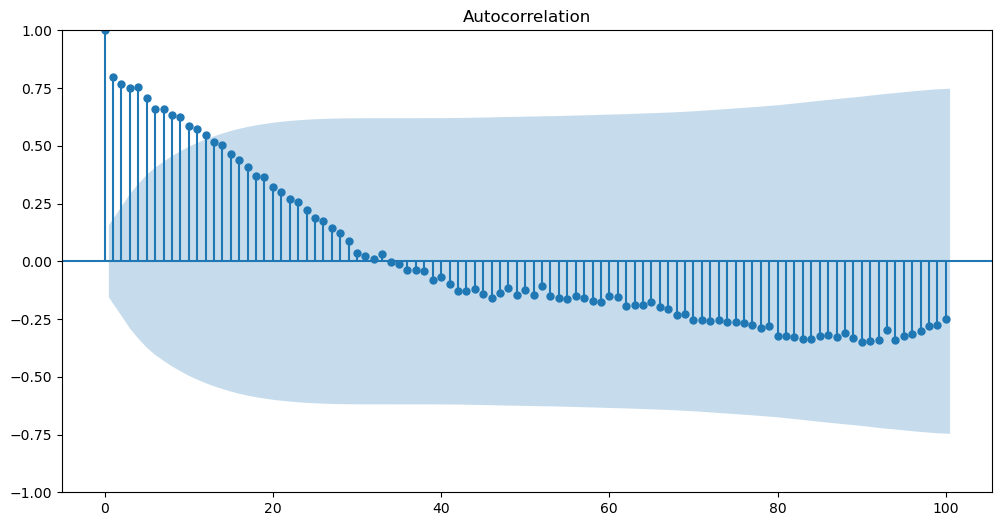

In [53]:
figure_acf = plot_acf(prices_amazon_week["open"], lags=100)
figure_acf.set_size_inches(12 ,6)

Where we have plot now the autocorrelation values against different lag values.

The **partial autocorrelation**, only is used the correlation between that observation and the previous observation that lags periods, and correlation effects from lower lag-value terms are removed.

And we plot this partial autocorrelation with ploy_pacf function:

/root/miniconda3/lib/python3.8/site-packages/statsmodels/graphics/tsaplots.py:348: FutureWarning:

The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.



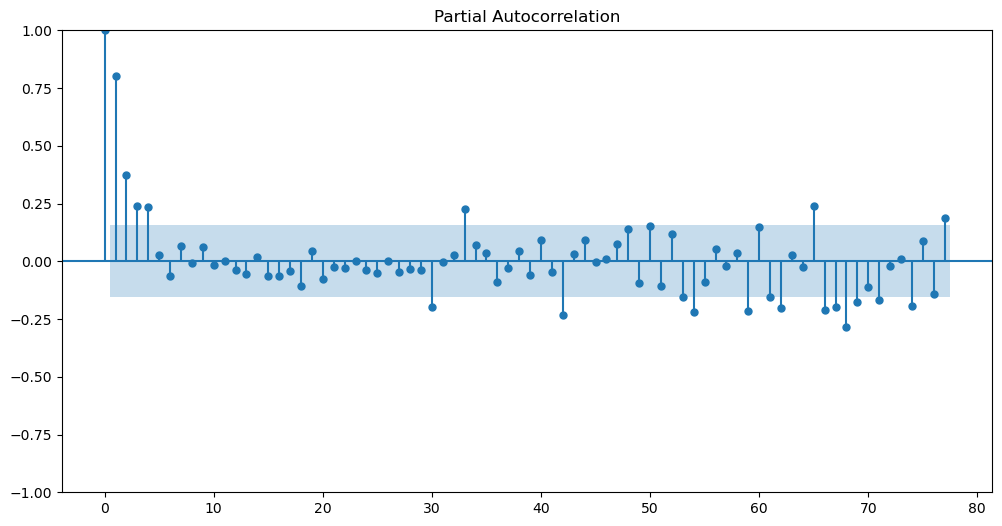

In [54]:
figure_pacf = plot_pacf(prices_amazon_week["open"], lags=77)
figure_pacf.set_size_inches(12 ,6)

We can see a huge drop in the autocorrelation after the first two lag terms and then we have variations that are increasing in frequency and absolute value.

### ARIMA

ARIMA is one of the most popular time-series forecasting model that is used for forecasting time series with correlated data points.

It has 3 components:
- **Auto-Regression**: the autocorrelation we obtained in the before cell. It accepts a parameter of how many lags to use, p.
- **Integrated**: the differencing transformation for the model to use to convert the time series into a stationary dataset. The parameter that accepts id d, which specifies the order of differencing to perform.
- **Moving Average**: applies MA to lagged observations. The parameter q, is the size of the window of the MA. We choose this value depending on which is the sharp drop-off in the partial autocorrelation plot past the lag value of 1. In Amazon, we can see it is in 4-5.


We are going to explore briefly this model here, but is going to be compared with other models in the forecasting application notebooks.

In [64]:
from statsmodels.tsa.arima.model import ARIMA

In [65]:
# We specify p=36, d=1, q=4
arima_model = ARIMA(prices_amazon_week["open"], order=(36, 1, 4))
res_ar = arima_model.fit()
res_ar.summary()

/root/miniconda3/lib/python3.8/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning:

Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.

/root/miniconda3/lib/python3.8/site-packages/statsmodels/base/model.py:604: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                   open   No. Observations:                  157
Model:                ARIMA(36, 1, 4)   Log Likelihood                -883.005
Date:                Tue, 27 Sep 2022   AIC                           1848.010
Time:                        09:07:35   BIC                           1973.054
Sample:                    09-29-2019   HQIC                          1898.797
                         - 09-25-2022                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.3694      0.224     -1.649      0.099      -0.808       0.070
ar.L2          0.8030      0.245      3.281      0.001       0.323       1.283
ar.L3          0.7936      0.192      4.137      0.000       0.418       1.170
ar.L4         -0.0592      0.221     -0.268      0.789      -0.492       0.374
ar.L5         -0.0402      0.220     -0.183      0.855      -0.472       0.391
ar.L6         -0.3570      0.216     -1.651      0.099      -0.781       0.067
ar.L7         -0.2872      0.170     -1.689      0.091      -0.620       0.046
ar.L8          0.0205      0.188      0.109      0.913      -0.348       0.389
ar.L9          0.1194      0.167      0.715      0.475      -0.208       0.447
ar.L10         0.0382      0.163      0.234      0.815      -0.281       0.358
ar.L11         0.0671      0.197      0.340      0.734      -0.320       0.454
ar.L12        -0.0237      0.182     -0.130      0.896      -0.381       0.334
ar.L13        -0.0963      0.171     -0.563      0.573      -0.432       0.239
ar.L14         0.0087      0.188      0.046      0.963      -0.359       0.376
ar.L15         0.1091      0.175      0.622      0.534      -0.235       0.453
ar.L16         0.0373      0.174      0.214      0.830      -0.303       0.378
ar.L17        -0.0274      0.184     -0.149      0.882      -0.388       0.333
ar.L18        -0.0517      0.187     -0.276      0.783      -0.419       0.315
ar.L19         0.0337      0.177      0.190      0.849      -0.314       0.381
ar.L20         0.0464      0.180      0.257      0.797      -0.307       0.400
ar.L21        -0.0587      0.189     -0.310      0.756      -0.429       0.312
ar.L22        -0.1242      0.185     -0.672      0.502      -0.486       0.238
ar.L23         0.0307      0.186      0.165      0.869      -0.334       0.395
ar.L24         0.0056      0.190      0.030      0.976      -0.367       0.378
ar.L25        -0.0065      0.180     -0.036      0.971      -0.358       0.345
ar.L26         0.1250      0.202      0.619      0.536      -0.271       0.520
ar.L27         0.1116      0.200      0.558      0.577      -0.280       0.503
ar.L28        -0.0281      0.242     -0.116      0.908      -0.503       0.447
ar.L29        -0.0319      0.195     -0.163      0.870      -0.415       0.351
ar.L30        -0.2306      0.194     -1.186      0.235      -0.611       0.150
ar.L31        -0.2679      0.195     -1.374      0.169      -0.650       0.114
ar.L32        -0.0144      0.201     -0.072      0.943      -0.408       0.379
ar.L33         0.3864      0.217      1.784      0.074      -0.038       0.811
ar.L34         0.1815      0.168      1.079      0.281      -0.148       0.511
ar.L35         0.0090      0.195      0.046      0.963      -0.374       0.392
ar.L36        -0.0297      0.141     -0.211      0.833      -0.306       0.246
ma.L1         -0.2239      0.210     -1.067      0.286      -0.635       0.188
ma.L2         -1.1463      0.184     -6.241      0.000      -1.506      -0.786
ma

<AxesSubplot:>

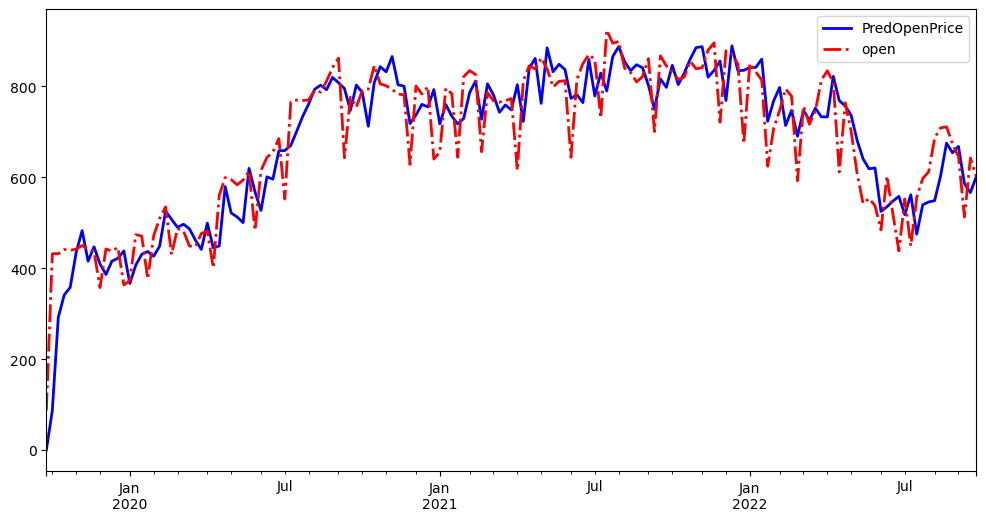

In [66]:
# We could make now a prediction of some values in the dataset (from the first index to the last)
prices_amazon_week["PredOpenPrice"] = res_ar.predict(
    prices_amazon_week.index[0],   # first index to predict, as it is datetime
    prices_amazon_week.index[-1]   # last index to predict
)

prices_amazon_week["PredOpenPrice"].plot(
    figsize=(12, 6), 
    color="blue", 
    linestyle="-", 
    lw=2, 
    legend="Prediction Open Price"
)

prices_amazon_week["open"].plot(
    figsize=(12, 6), 
    color="red", 
    linestyle="-.", 
    lw=2, 
    legend="Actual Open Price"
)

In [67]:
from statsmodels.tsa.base.datetools import dates_from_range

In [68]:
# We create index for 48 more months starting in 9 month of 2022
extended_amazon_df = pd.DataFrame(index=dates_from_range('2022m9', length=48))
extended_amazon_df = prices_amazon_week.append(extended_amazon_df)
extended_amazon_df

/tmp/ipykernel_11/4127092102.py:3: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.



,open,high,low,close,PredOpenPrice
2019-09-29,87.400002,87.456001,85.691002,86.272499,0.000000
2019-10-06,431.987511,434.376503,427.346001,432.443001,87.089577
2019-10-13,432.094498,434.425995,429.333496,430.617004,292.008927
2019-10-20,441.433502,444.870491,438.217995,441.311508,341.475966
2019-10-27,439.387505,444.913002,436.213493,442.783493,357.918252
...,...,...,...,...,...
2026-04-30,NaN,NaN,NaN,NaN,NaN
2026-05-31,NaN,NaN,NaN,NaN,NaN
2026-06-30,NaN,NaN,NaN,NaN,NaN
2026-07-31,NaN,NaN,NaN,NaN,NaN


<AxesSubplot:>

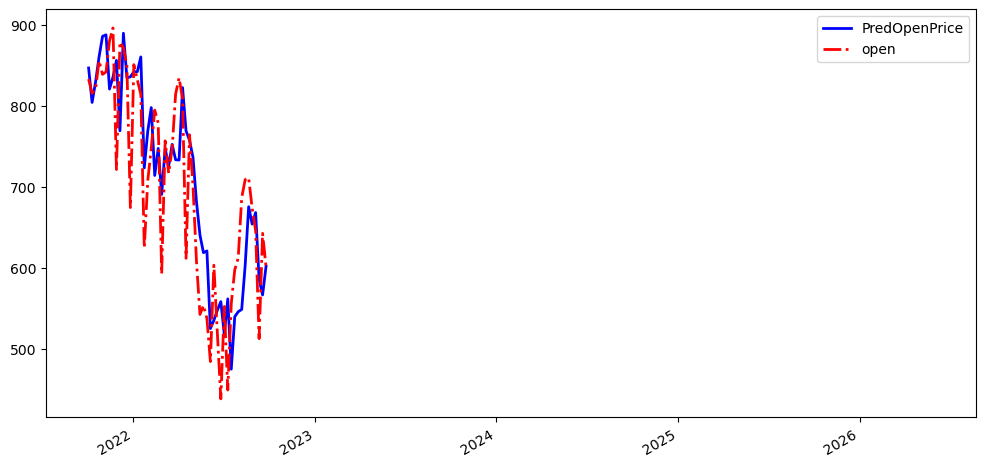

In [69]:
extended_amazon_df["PredOpenPrice"] = res_ar.predict(extended_amazon_df.index[0], extended_amazon_df.index[-1])

extended_amazon_df["PredOpenPrice"].iloc[-100:].plot(
    figsize=(12, 6), 
    color="blue", 
    linestyle="-", 
    lw=2, 
    legend="Prediction Open Price"
)

extended_amazon_df["open"].iloc[-100:].plot(
    figsize=(12, 6), 
    color="red", 
    linestyle="-.", 
    lw=2, 
    legend="Actual Open Price"
)

In [70]:
# We can see that the model is not able to make prediction correctly
extended_amazon_df.tail(10)

,open,high,low,close,PredOpenPrice
2025-11-30,NaN,NaN,NaN,NaN,520.186958
2025-12-31,NaN,NaN,NaN,NaN,NaN
2026-01-31,NaN,NaN,NaN,NaN,NaN
2026-02-28,NaN,NaN,NaN,NaN,NaN
2026-03-31,NaN,NaN,NaN,NaN,NaN
2026-04-30,NaN,NaN,NaN,NaN,NaN
2026-05-31,NaN,NaN,NaN,NaN,542.002484
2026-06-30,NaN,NaN,NaN,NaN,NaN
2026-07-31,NaN,NaN,NaN,NaN,NaN
2026-08-31,NaN,NaN,NaN,NaN,NaN


### SARIMAX

**SARIMA** is an extension of ARIMA for univariate time series, with seasonal component. The paramters it has are:
- p = trend auto-regressive order
- d = trend difference order. The tests:
    - Kwiatkowski-Phillips-Schmidt-Shin: KPSS
    - Augmented Dickey-Fuller: ADF
    - Phillips-Perron: PP
- q = trend MA order
- p = seasonal auto-regressive order
- D = seasonal difference order
    - Canova-Hansen: CH
- Q = seasonal MA order
- m = the length of a single seasonal period in the number of time steps



**SARIMAX** also supports exogenours variables.

The auto-ARIMA modle tries to find automatically the SARIMAX parameters by conducting the tests.

Once we have the optimal *d*, the auto-ARIMA model searches for the best model by trying values in the range of *start_p*, *max_p*, *start_q*, *max_q*.

If seasonal feature is enabled, once determined d, we will find also the P and Q.

The best model is the one that minimized the value of the information criterion:
- **Akaike Information Criterion**
- **Corrected AIC**
- **Bayesion Informaiton Criterion**
- **Out-Of-Bag**: for validation scoring

If not model is suitable, we would obtain back a *ValueError*.

In [13]:
import pmdarima as pm
model = pm.auto_arima(
    prices_amazon_week["open"], 
    seasonal=True, 
    stepwise=True, 
    m=52   # as it is in weeks, one complete season (one year) = 52 weeks
)
model.summary()

NameError: name 'prices_amazon_week' is not defined

In [72]:
# We can also make the prediction
extended_amazon_df["PredOpenPrice"], conf_int = model.predict(
    48, 
    return_conf_int=True, 
    alpha=0.05   # 95% of confidence interval
)

plt.plot(prices_amazon_week["open"], c="red")
plt.plot(extended_amazon_df["PredOpenPrice"], c="blue")
plt.show()

NameError: name 'model' is not defined

In [ ]:
extended_amazon_df["PredOpenPrice"], conf_int = model.predict(48, return_conf_int=True, alpha=0.05)

In [ ]:
extended_amazon_df

### FB Prophet

Used for univariate time series with strong support for seasonality and holiday effects.

Very suitable for time series with frequent changes of trends and very robust to handle outliers.

It is an additive regression model with:
- Piecewise linear or logistic growth trend
- Yearly seasonal component modeled with a Fourier series
- Weekly seasonal component modeled with dummy variables
- A user-provided list of holidays

In [6]:
from prophet import Prophet

In [7]:
# First we clean our dataframe to be bale to apply the model
df = amazon_weekly["open"]
df = df.reset_index()
df.columns = ["ds", "y"]
df

,ds,y
0,2019-09-27,87.400002
1,2019-09-30,86.349503
2,2019-10-01,87.300003
3,2019-10-02,86.387001
4,2019-10-03,85.650002
...,...,...
749,2022-09-19,122.160004
750,2022-09-20,123.349998
751,2022-09-21,122.489998
752,2022-09-22,117.080002


In [ ]:
prices_amazon_week

In [9]:
model = Prophet()
model = model.fit(df)

09:51:58 - cmdstanpy - INFO - Chain [1] start processing
09:51:58 - cmdstanpy - INFO - Chain [1] done processing


findfont: Font family ['Heiti TC'] not found. Falling back to DejaVu Sans.


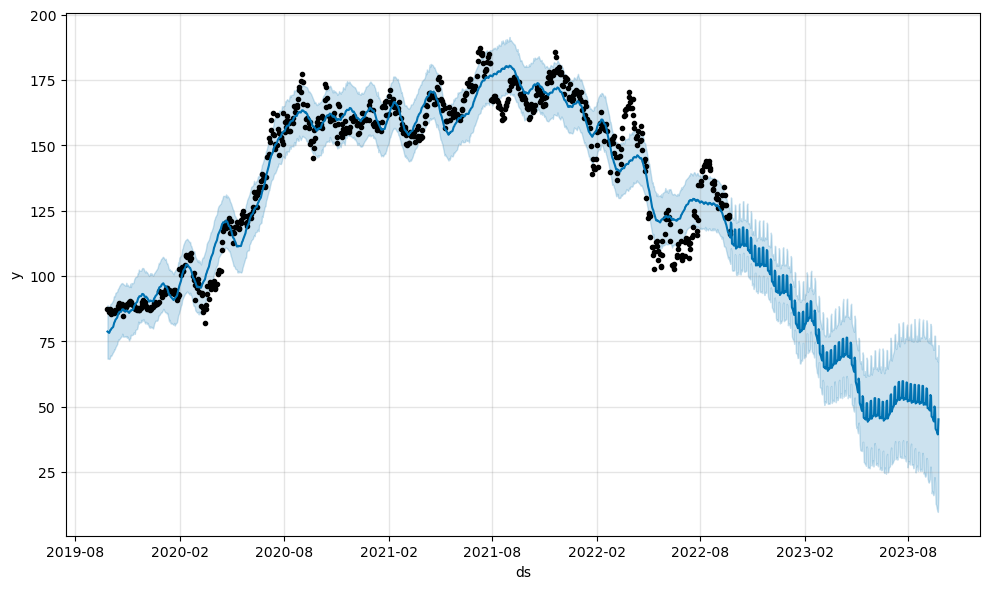

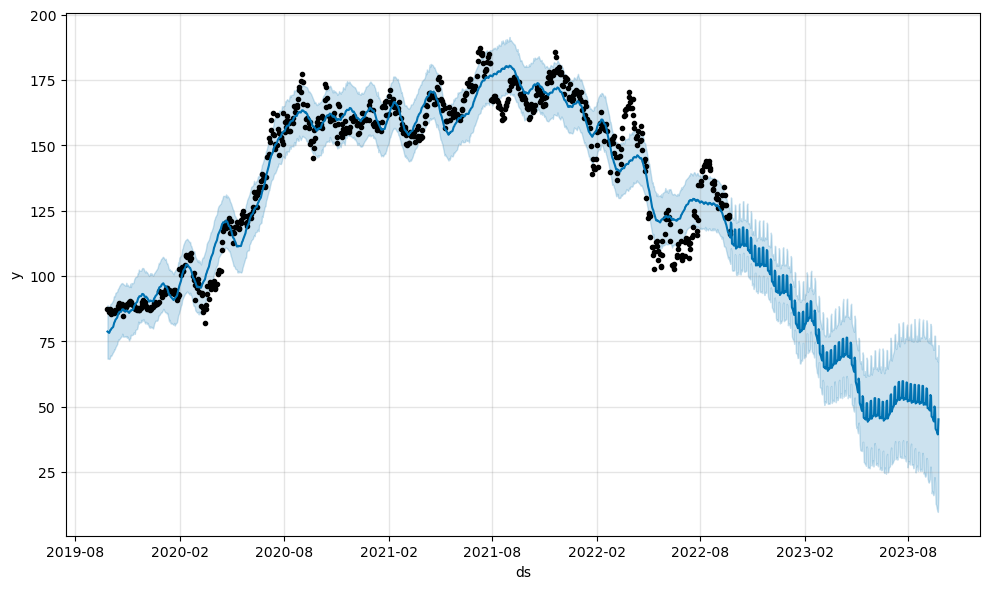

In [12]:
future = model.make_future_dataframe(periods=365)
forecast = model.predict(future)

model.plot(forecast)

In [16]:
comp_plot = model.plot_components_plotly(forecast)
comp_plot

AttributeError: 'Prophet' object has no attribute 'plot_components_plotly'

- TODO: Compare with NeuralProphet  --> forecasting notebooks
- TODO: Add holidays --> data injestion

### RidgeCV Regression

It is a linear regression model with L2 regularization (to  avoid overfitting) with Cross-Validation to get the optimal coefficients.

In [17]:
from sklearn.linear_model import RidgeCV

ridge = RidgeCV()

In [28]:
# We can test to predict the price of the next day based on the day before features
amazon_weekly["nextOpen"] = amazon_weekly["open"].shift(1)
amazon_weekly_cleaned = amazon_weekly.drop(amazon_weekly.index[0], axis=0)

target = amazon_weekly_cleaned["nextOpen"]
features = amazon_weekly_cleaned.drop(["nextOpen", "ticker"], axis=1)

In [29]:
ridge.fit(features, target)

RidgeCV(alphas=array([ 0.1,  1. , 10. ]))

In [30]:
# Once we have the model fitted, we can obtain the coefficients
ridge.coef_

array([ 8.73540323e-01,  3.72454711e-01, -1.61157524e-01, -4.74857738e-02,
       -4.74857738e-02, -3.08454037e-06])

In [31]:
# And we can obtain the R2 score
ridge.score(features, target)

-12.657283155358204

<AxesSubplot:>

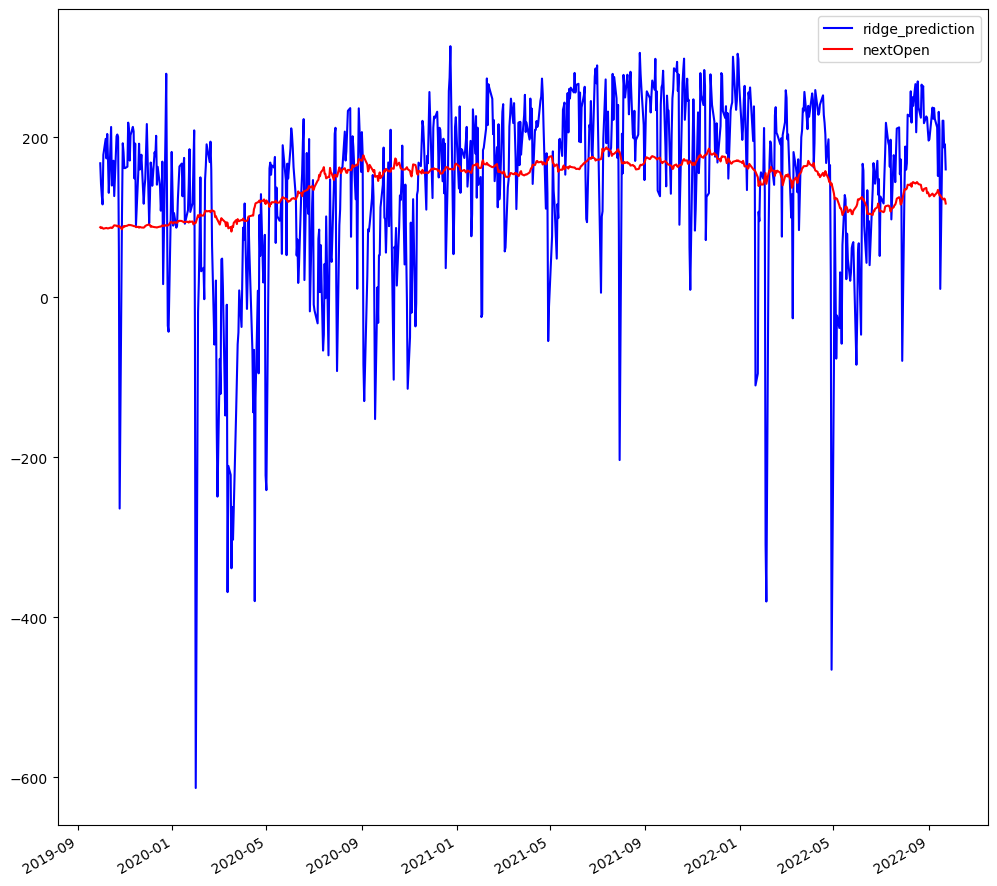

In [39]:
# Obviously, the market price of amazon can't be negative
amazon_weekly_cleaned["ridge_prediction"] = ridge.predict(features)


amazon_weekly_cleaned["ridge_prediction"].plot(figsize=(12, 12), legend="Prediction Ridge", color="blue")
amazon_weekly_cleaned["nextOpen"].plot(figsize=(12, 12), legend="Real Open Price", color="red")

<AxesSubplot:ylabel='Density'>

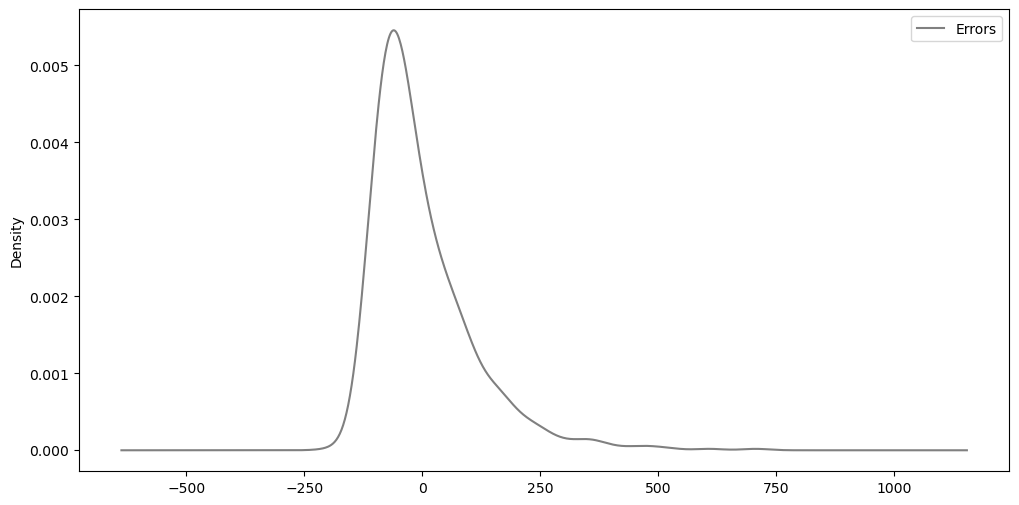

In [42]:
# And we can compare the errors
amazon_weekly_cleaned["Errors"] = amazon_weekly_cleaned["nextOpen"] - amazon_weekly_cleaned["ridge_prediction"]
amazon_weekly_cleaned["Errors"].plot(
    figsize=(12, 6), 
    color="gray", 
    kind="kde", 
    legend="errors"
)

- TODO: Make sure that when making forecast, the errors are distributed normally

### Random Forest Classificator

We can classify based on the before results, if the company price is going to be up or down.

In [51]:
amazon_weekly_cleaned["diff"] = amazon_weekly_cleaned["nextOpen"] - amazon_weekly_cleaned["open"]

def convert_class(row):
    if row["diff"] > 0:
        return "upper"
    
    elif row["diff"] < 0:
        return "lower"
    
    else:
        return "equal"
        

amazon_weekly_cleaned["classification"] = amazon_weekly_cleaned.apply(lambda x: convert_class(x), axis=1)

In [50]:
amazon_weekly_cleaned

,open,high,low,close,adjclose,volume,ticker,nextOpen,ridge_prediction,Errors,classification,diff
2019-09-30,86.349503,86.873001,85.460999,86.795502,86.795502,52894000,AMZN,87.400002,167.383037,-79.983035,upper,1.050499
2019-10-01,87.300003,87.779999,86.420502,86.782501,86.782501,61690000,AMZN,86.349503,141.266139,-54.916637,lower,-0.950500
2019-10-02,86.387001,86.444504,85.250000,85.661499,85.661499,66022000,AMZN,87.300003,126.904053,-39.604050,upper,0.913002
2019-10-03,85.650002,86.250000,84.252998,86.221001,86.221001,69364000,AMZN,86.387001,115.986814,-29.599813,upper,0.737000
2019-10-04,86.301003,87.028999,85.961502,86.982498,86.982498,49438000,AMZN,85.650002,177.960524,-92.310523,lower,-0.651001
...,...,...,...,...,...,...,...,...,...,...,...,...
2022-09-19,122.160004,124.709999,121.800003,124.660004,124.660004,47279700,AMZN,122.779999,220.622702,-97.842703,upper,0.619995
2022-09-20,123.349998,124.400002,121.139999,122.190002,122.190002,47698400,AMZN,122.160004,220.596198,-98.436194,lower,-1.189995
2022-09-21,122.489998,123.760002,118.449997,118.540001,118.540001,58498900,AMZN,123.349998,187.072164,-63.722166,upper,0.860001
2022-09-22,117.080002,118.790001,116.260002,117.309998,117.309998,55229200,AMZN,122.489998,191.050485,-68.560487,upper,5.409996


<AxesSubplot:>

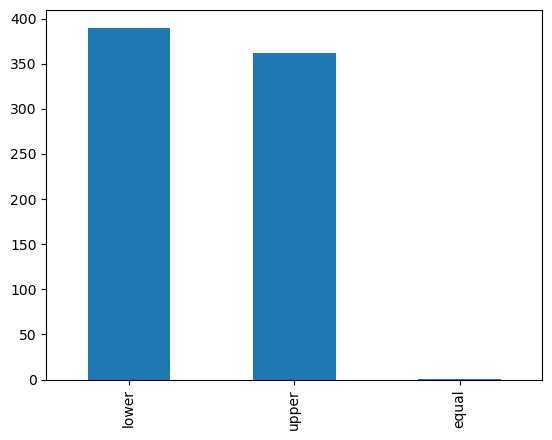

In [55]:
# We can make a plot
amazon_weekly_cleaned["classification"].value_counts().plot(kind="bar")

- TODO: We will be doing both forecasting price (to know which will be the profitability), as well as classification with a different model

## Parsing Financial Data Amazon

TODO: Check for nest_asyncio.apply() and async way to request for data.

In [81]:
url = "https://es.finance.yahoo.com/quote/AMZN/financials?p=AMZN"
res = requests.get(url)
pd.read_html(
    res.text
)

[                                                   0
 0  Will be right back...  Thank you for your pati...]

# S&P 500 Companies

In [75]:
# We can get the S&P500 companies by reading directly to the table of wikipedia
wiki_url = "https://en.wikipedia.org/wiki/List_of_S%26P_500_companies"


res = requests.get(wiki_url)

sp_companies = pd.read_html(
    res.text, 
    header=0, 
    )[0]

sp_companies.head()

,Symbol,Security,SEC filings,GICS Sector,GICS Sub-Industry,Headquarters Location,Date first added,CIK,Founded
0,MMM,3M,reports,Industrials,Industrial Conglomerates,"Saint Paul, Minnesota",1976-08-09,66740,1902
1,AOS,A. O. Smith,reports,Industrials,Building Products,"Milwaukee, Wisconsin",2017-07-26,91142,1916
2,ABT,Abbott,reports,Health Care,Health Care Equipment,"North Chicago, Illinois",1964-03-31,1800,1888
3,ABBV,AbbVie,reports,Health Care,Pharmaceuticals,"North Chicago, Illinois",2012-12-31,1551152,2013 (1888)
4,ABMD,Abiomed,reports,Health Care,Health Care Equipment,"Danvers, Massachusetts",2018-05-31,815094,1981


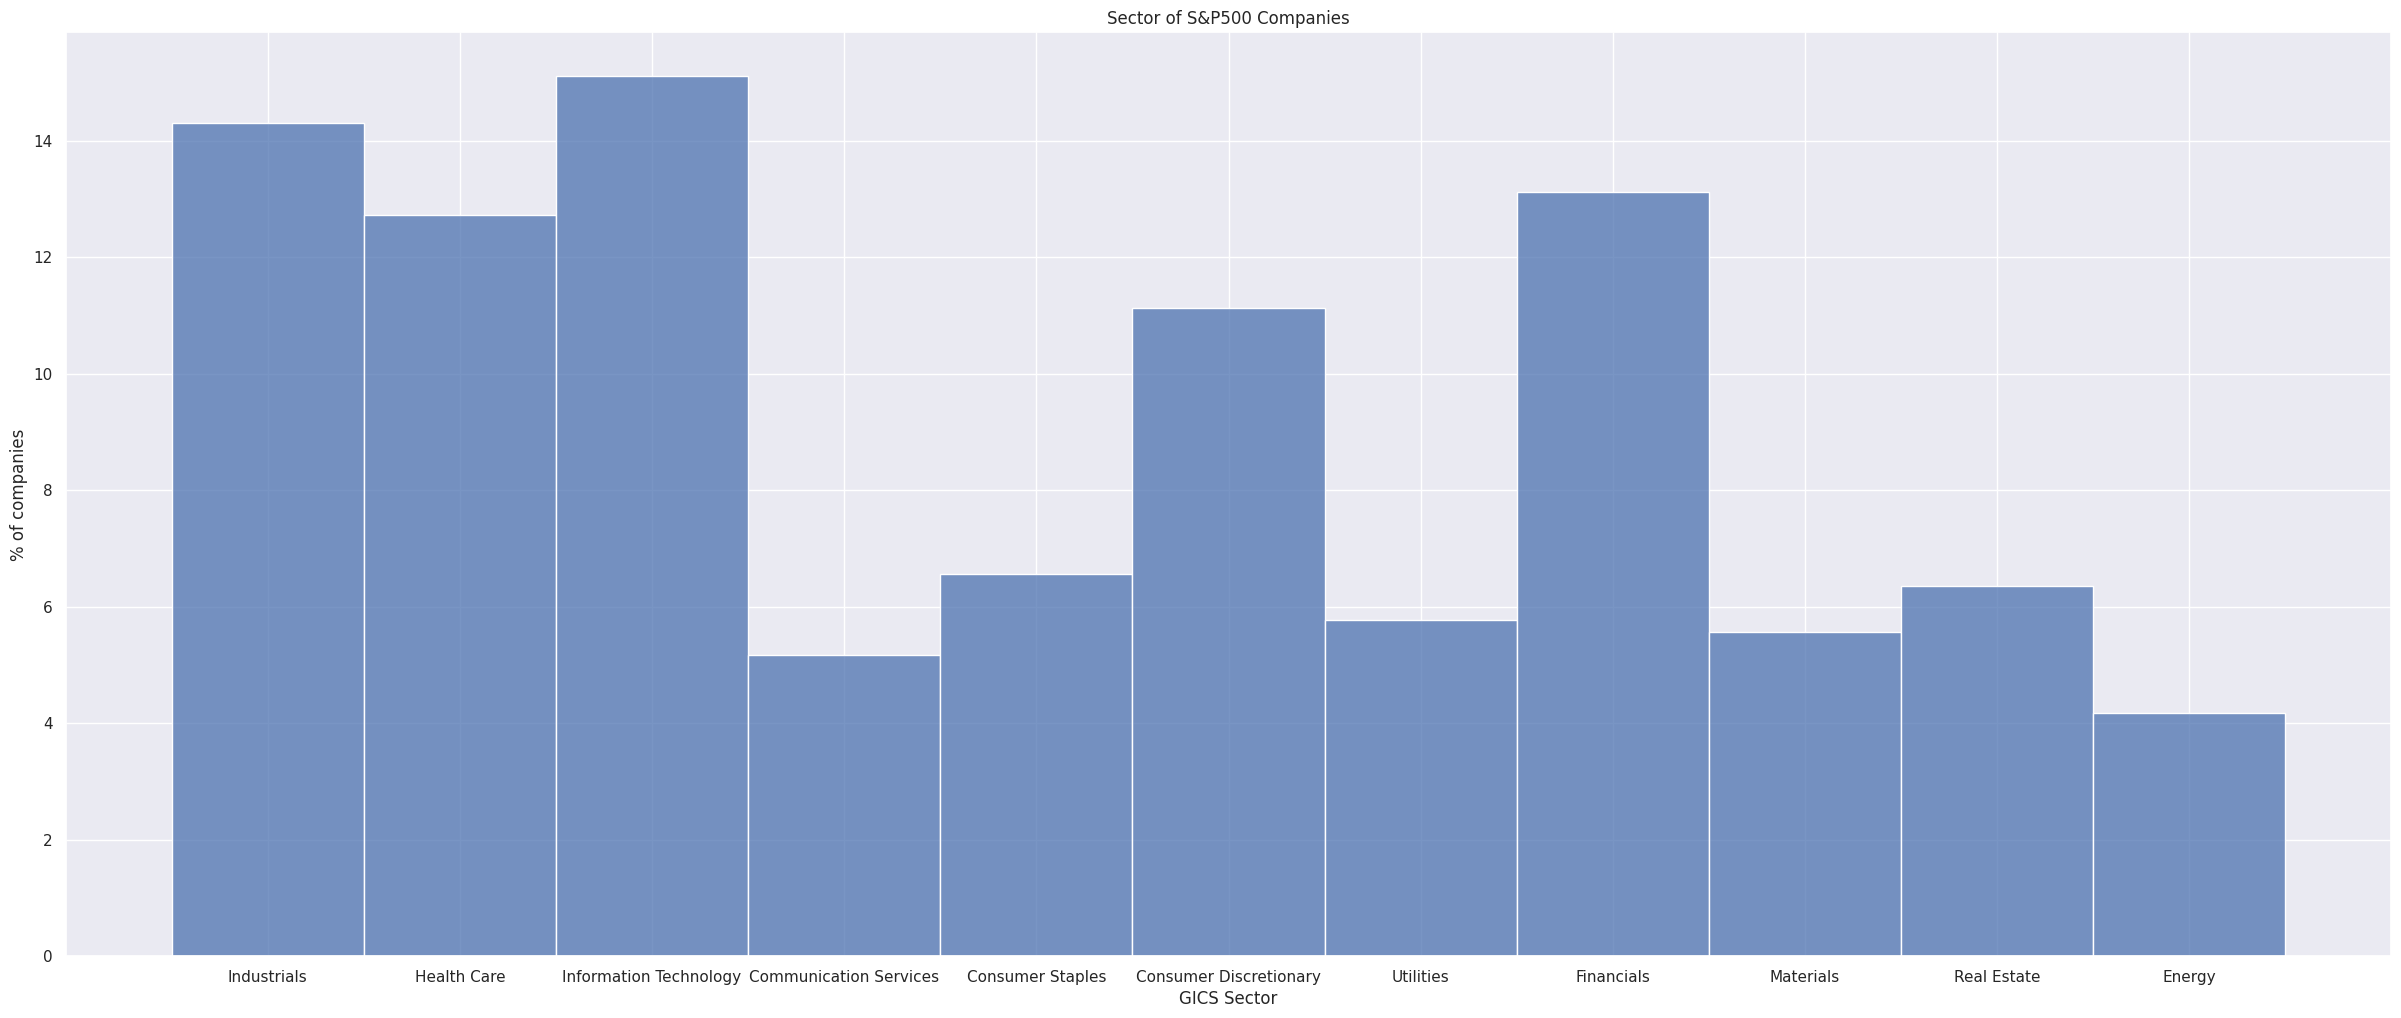

In [138]:
sns.set(style="darkgrid")

plt.figure(figsize=(30,12))

sns.histplot(
    data=sp_companies, 
    x="GICS Sector",
    stat="percent"
)

plt.title("Sector of S&P500 Companies")
plt.ylabel("% of companies")
plt.xlabel("GICS Sector")
plt.show()

In [90]:
# Select the companies that have changed
sp_companies_changed = pd.read_html(wiki_url, header=1)[1]
sp_companies_changed.head()

,Date,Ticker,Security,Ticker.1,Security.1,Reason
0,"September 19, 2022",CSGP,CoStar Group,PVH,PVH,Market capitalization change.[4]
1,"September 19, 2022",INVH,Invitation Homes,PENN,Penn Entertainment,Market capitalization change.[4]
2,"June 21, 2022",KDP,Keurig Dr Pepper,UA/UAA,Under Armour,Market capitalization change.[5]
3,"June 21, 2022",ON,ON Semiconductor,IPGP,IPG Photonics,Market capitalization change.[5]
4,"June 8, 2022",VICI,Vici Properties,CERN,Cerner,S&P 500 constituent Oracle Corp. acquired Cern...


- TODO: When computing delta_prices_perc, check for 0 in the divisor

- TODO: PCA to detect in each case, which features to use -> feature engineering.
    - https://medium.com/@data.science.enthusiast/feature-selection-techniques-forward-backward-wrapper-selection-9587f3c70cfa

